<a href="https://www.kaggle.com/code/arieswang98/titanic-ml-01?scriptVersionId=112734484" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [8]:
import numpy as np 
import pandas as pd

import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
import scikitplot as skplt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [11]:
# Read data 
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# basic info
print('\n'+'Some basic information about the train dataset'+'\n')
train.info()

print('\n'+'Some basic information about the test dataset'+'\n')
test.info()


Some basic information about the train dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Some basic information about the test dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  


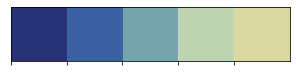

In [14]:
## Plot
cm = ["#273176","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1"]
gradient = ["#292F55","#273176","#223A92","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1","#C7B679","#957447"]
sns.palplot(cm)

In [13]:
# how much % missing values 
total_missing_train = pd.DataFrame(train.isnull().sum() / train.shape[0] * 100, 
                                   columns=["% (train)"])
total_missing_test = pd.DataFrame(test.isnull().sum() / test.shape[0] * 100, 
                                  columns=["% (test)"])
missing = pd.concat([total_missing_train, total_missing_test], axis=1)
missing.T

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
% (train),0.0,0.0,0.0,0.0,0.0,19.865320,0.0,0.0,0.0,0.000000,77.104377,0.224467
% (test),0.0,NaN,0.0,0.0,0.0,20.574163,0.0,0.0,0.0,0.239234,78.229665,0.000000


In [ ]:
# describe data
train.describe()

In [ ]:
test.describe()

{'B', 'F', 'A', 'D', 'G', 'E', 'N/A', 'T', 'C'}


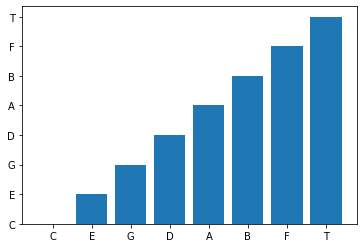

In [30]:
##  Data analysis
# Cabin location & Pclass
df = train.copy()
df['Cabin_location'] = df['Cabin'].str[:1]
df['Cabin_location'] = df['Cabin_location'].replace(np.nan,"N/A")
print(set(df['Cabin_location'].values))
df["Survived"] = df["Survived"].astype(str)
df = df[df['Cabin_location']!="N/A"]

plt.bar(list(df['Cabin_location'].values), df['Cabin_location'])
plt.show()
    
# fig = px.histogram(df, x='Pclass')
# fig.show()
# Survived & Cabin location

In [14]:
# Feature engineering
## Proprecess data
train['Sex'].replace('male', 0 ,inplace= True)
train['Sex'].replace('female', 1 ,inplace= True)
train['Relation'] = train['SibSp']+train['Parch']
train['Ifhavekid'] = train['Parch']
train['Ifhavekid'][train['Ifhavekid']>0] = 1

dfresult = pd.DataFrame()
df = pd.get_dummies(train['Embarked'])
df.columns = ['Embarked_' +str(x) for x in df.columns ]
train = pd.concat([train,df],axis = 1)

train.Age = (train.Age-min(train.Age))/(max(train.Age)-min(train.Age))
train.Fare = (train.Fare-min(train.Fare))/(max(train.Fare)-min(train.Fare))

test['Sex'].replace('male', 0 ,inplace= True)
test['Sex'].replace('female', 1 ,inplace= True)
test['Relation'] = test['SibSp']+test['Parch']
test['Ifhavekid'] = test['Parch']
test['Ifhavekid'][test['Ifhavekid']>0] = 1

dfresult = pd.DataFrame()
df = pd.get_dummies(test['Embarked'])
df.columns = ['Embarked_' +str(x) for x in df.columns ]
test = pd.concat([test,df],axis = 1)

test.Age = (test.Age-min(test.Age))/(max(test.Age)-min(test.Age))
test.Fare = (test.Fare-min(test.Fare))/(max(test.Fare)-min(test.Fare))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
class create_feature:
    def multiple(df):
        res = df.copy()
        names = df.columns.tolist()
        for i in range(df.shape[1]-1):
            col1 = df.iloc[:, i].astype(float)
            for j in range(i+1, df.shape[1]):
                col2 = df.iloc[:, j].astype(float)
                new_col = col1*col2
                new_name = names[i]+'*'+names[j]
                res = pd.concat([res, pd.Series(new_col)], axis=1)
                names.append(new_name)
                res.columns = names
        return res
        
    

In [63]:
## Feature importance
X = pd.concat([train['Pclass'],
               train['Sex'], train['Age'], train['SibSp'], train['Parch'],  
               train['Relation'], train['Fare']],axis=1)
for column in X:
    if np.any(X[column].isnull()):
        mean_val = np.mean(X[column])
        X[column].fillna(mean_val, inplace=True)
        
# X = create_feature.multiple(X)

y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=913)
from sklearn.ensemble import RandomForestClassifier
rfc =  RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
# print(rfc.feature_importances_)
d = {}
for i in range(len(X.columns)):
    d[X.columns[i]] = rfc.feature_importances_[i]  
feature_importances_d = sorted(d.items(), key=lambda item: item[1], reverse=True)
print(feature_importances_d)
for item in d:
    if d[item] < 0.005:
        X.drop(item, axis=1, inplace=True)
print(X.columns)

[('Fare', 0.29453574317480313), ('Age', 0.2681860821922748), ('Sex', 0.2574249683498124), ('Pclass', 0.08283235441119803), ('Relation', 0.04797074916819965), ('SibSp', 0.028115676444655225), ('Parch', 0.02093442625905677)]
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Relation', 'Fare'], dtype='object')


In [64]:
# RandomForest model
rfc = RandomForestClassifier(min_samples_split=5,
                           min_samples_leaf=2, max_depth=5,
                           random_state=0, n_estimators=100)
model = rfc.fit(X_train, y_train)
y_predict = model.predict(X_test) 
print(y_predict)
print(accuracy_score(y_test, y_predict))

[0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0
 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1
 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
0.8156424581005587


In [65]:
# GradientBoostingClassifier model
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(learning_rate=0.01, min_samples_split=5,
                                          min_samples_leaf=2, max_depth=5, max_features='sqrt', 
                                          subsample=1, random_state=0)
model = clf.fit(X_train, y_train)  
y_predict = model.predict(X_test) 
print(accuracy_score(y_test, y_predict))

0.8156424581005587


In [62]:
# Xgboost model
dtrain = xgb.DMatrix(X_train, y_train)
param = {'seed': 0, 
         'max_depth': 10, 
         'eta': 0.001, 
         'objective': 'binary:logistic', 
         'subsample': 1,
         'lambda': 2}
param['eval_metric'] = 'auc'
num_round = 100
dtest = xgb.DMatrix(X_test, y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
y_pred = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
y_predict = (y_pred >= 0.5)*1
# y_predict = [round(i) for i in y_pred] 
print(accuracy_score(y_test, y_predict))

[0]	train-auc:0.88165	eval-auc:0.87472
[1]	train-auc:0.88196	eval-auc:0.87428
[2]	train-auc:0.88200	eval-auc:0.87421
[3]	train-auc:0.88205	eval-auc:0.87421
[4]	train-auc:0.88207	eval-auc:0.87396
[5]	train-auc:0.88198	eval-auc:0.87396
[6]	train-auc:0.88196	eval-auc:0.87371
[7]	train-auc:0.88198	eval-auc:0.87396
[8]	train-auc:0.88197	eval-auc:0.87383
[9]	train-auc:0.88197	eval-auc:0.87371
0.8268156424581006


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:571: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


In [47]:
# Xgboost Prediction
data_to_pred = pd.concat([test['Pclass'], test['Sex'], test['Age'], 
                          test['SibSp'], test['Parch'], test['Relation'], 
                          test['Fare']],axis=1)
for column in data_to_pred:
    if np.any(data_to_pred[column].isnull()):
        mean_val = np.mean(data_to_pred[column])
        data_to_pred[column].fillna(mean_val, inplace=True)
        
# data_to_pred = create_feature.multiple(data_to_pred)

data_to_pred = xgb.DMatrix(data_to_pred)
prediction = bst.predict(data_to_pred, iteration_range=(0, bst.best_iteration + 1))
prediction = (prediction >= 0.5)*1
res = pd.concat([test['PassengerId'], pd.Series(prediction)], axis=1)
res.columns = ['PassengerId', 'Survived']
res.to_csv('/kaggle/working/submission.csv', index=False)
print('over')

over


In [51]:
# Predict
data_to_pred = pd.concat([test['Pclass'], test['Sex'], test['Age'], 
                          test['SibSp'], test['Parch'], test['Relation'], 
                          test['Fare']],axis=1)
for column in data_to_pred:
    if np.any(data_to_pred[column].isnull()):
        mean_val = np.mean(data_to_pred[column])
        data_to_pred[column].fillna(mean_val, inplace=True)

# data_to_pred = create_feature.multiple(data_to_pred)

prediction = model.predict(data_to_pred)
res = pd.concat([test['PassengerId'], pd.Series(prediction)], axis=1)
res.columns = ['PassengerId', 'Survived']
res.to_csv('/kaggle/working/submission.csv', index=False)
print('over')

over


In [32]:
tips = px.data.tips()
fig = px.histogram(tips, x="total_bill")
fig.show()